<a href="https://colab.research.google.com/github/tmgrgg/nlp-mafiascum/blob/master/UpgradedMafiascumLSTMUsingTorchTextV2_SIGMOIDAL_GLOVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello Gentlemen

### Your mission (should you choose to accept it), is to help me figure out two things:

1. In the final training loop, the GPU runs out of memory when running on the whole dataset. Is there an underlying mistake causing this or is it unavoidable with how things we have set up here? If so, how can we set them up so that we don't lose too much speed but we are still able to train on the whole dataset? 

2. Why on earth do my loss curves show that this model is completely failing to learn? Again, is there an underlying mistake, or is this simply a matter of finding the right parameters? 

I'll try to make this notebok really clear so as to help you guys help me, but please let me know if you have any questions.

## Mount Drive!

In [0]:
#We'll need this to be able to cache stuff without blowing up RAM

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Get GPU

In [0]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

Load the 10,000 documents and their predefined features in as a dataframe


In [0]:
!git clone https://bitbucket.org/bopjesvla/thesis.git
!mv thesis/src/* .

Cloning into 'thesis'...
remote: Counting objects: 220, done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 220 (delta 19), reused 0 (delta 0)
Receiving objects: 100% (220/220), 734.99 MiB | 14.60 MiB/s, done.
Resolving deltas: 100% (96/96), done.
Checking out files: 100% (58/58), done.


In [0]:
import pandas as pd
docs = pd.read_pickle('docs.pkl', compression='gzip')

# check that all is well
docs.head()

,game_id,author,content,inserted_at,updated_at,scum,slot_id,words,wc,punc,or_ratio,fpp_ratio,tpp_ratio,but_ratio,token_length,unique_tokens,message_count,message_length,sentence_length,time,wc24h,msg24h,vector_FastText_wiki,vector_GloVe_wiki200d,vector_GloVe_wiki,vector_GloVe_twitter,neg_ratio,neg_em_ratio,not_ratio,anger_ratio,sensory_ratio,cog_ratio,insight_ratio,motion_ratio,tent_ratio,spp_ratio,quant_ratio
0,28480,ThAdmiral,yep /!@ \nWhat if he is scum? This option woul...,2013-05-15 01:44:00,2013-07-22 00:17:00,False,240,"[yep, what, if, he, is, scum, this, option, wo...",2688,"[/!@, ?, ', ., :, ', ., /!@, ., ., ., /!@, (, ...",0.003348,0.042039,0.023065,0.006696,4.302455,0.221726,64,42.000000,0.087426,68.939583,38.990662,0.928349,"[-0.11273227513899668, 0.018551131866316774, -...","[0.16055721, 0.19409353, -0.09813492, -0.11749...","[-0.11783043, 0.09800706, -0.05116942, -0.0682...","[0.089912206, 0.19500107, 0.054465882, 0.10074...",0.018601,0.013393,0.018601,0.005952,0.017857,0.081101,0.024926,0.004836,0.029762,0.012649,0.013393
1,5845,Khelvaster,"[s]Gah...I don't know anyone. Vote: SPAG, sinc...",2007-08-02 16:33:00,2007-08-27 20:07:00,False,5210,"[s, gah, i, don, t, know, anyone, vote, spag, ...",863,"[[, ], ..., ', ., :, ,, ', .[/, ], ,, ', ..., ...",0.002317,0.042874,0.022016,0.005794,4.067207,0.403244,15,57.533333,0.092700,26.148611,33.003665,0.573644,"[-0.10023690888810728, 0.020833695785571843, -...","[0.14646702, 0.25892192, -0.08927924, -0.17455...","[-0.11812947, 0.10565025, -0.06426784, -0.1109...","[0.0961927, 0.19491331, 0.0321678, 0.071879774...",0.031286,0.006952,0.031286,0.001159,0.016222,0.077636,0.017381,0.006952,0.034762,0.027810,0.015064
2,30779,Elyse,/confirm /!@ ANNOUNCEMENT\nThere are NO jester...,2013-08-13 15:28:00,2013-10-11 00:52:00,False,447,"[confirm, announcement, there, are, no, jester...",3194,"[/, /!@, ,, ., ', !, /!@, ., :, /!@, ', /!@, '...",0.001252,0.051659,0.027239,0.008453,3.933626,0.229493,111,28.774775,0.130244,59.391667,53.778588,1.868949,"[-0.09363476607418539, 0.028349871196682513, -...","[0.17497152, 0.21025513, -0.10277278, -0.15136...","[-0.102921024, 0.0764547, -0.06794854, -0.0842...","[0.10085423, 0.16621116, 0.044601005, 0.105791...",0.033500,0.017533,0.033500,0.003444,0.028491,0.100188,0.027552,0.005322,0.022855,0.029430,0.011271
3,10744,Simpor,/confirm /!@ Vote: AWA\n\nFor being the last o...,2009-03-04 21:42:00,2009-03-14 21:23:00,True,6238,"[confirm, vote, awa, for, being, the, last, on...",154,"[/, /!@, :, .., /!@, ,, ?, !, /!@, ', ,, ., ',...",0.000000,0.064935,0.012987,0.006494,4.071429,0.649351,5,30.800000,0.103896,10.986806,14.016813,0.455091,"[-0.1328930663044335, 0.0116366885769277, -0.0...","[0.15854017, 0.26437867, -0.03646247, -0.20398...","[-0.16914089, 0.11391469, -0.057118926, -0.110...","[0.12944503, 0.13376419, 0.008241472, 0.091873...",0.025974,0.006494,0.025974,0.006494,0.012987,0.090909,0.019481,0.000000,0.032468,0.012987,0.038961
4,10617,blakebowling,"Confirm /!@ Vote: blakebowling /!@ Unvote, Vot...",2009-02-20 02:08:00,2009-03-01 03:10:00,False,6200,"[confirm, vote, blakebowling, unvote, vote, at...",239,"[/!@, :, /!@, ,, :, ., ', ., /!@, /!@, ,, .[/,...",0.000000,0.062762,0.004184,0.000000,3.928870,0.577406,12,19.916667,0.121339,10.043056,23.797538,1.194855,"[-0.11159829518160562, 0.030154899912205217, -...","[0.14067383, 0.29263738, -0.18649453, -0.12949...","[-0.089610584, 0.1020354, -0.11109041, -0.0602...","[0.17050445, 0.18049765, 0.07405566, -0.003876...",0.037657,0.025105,0.037657,0.008368,0.016736,0.050209,0.012552,0.020921,0.020921,0.016736,0.000000


### Remove large documents 

I have to do this at the moment because of issue 1. above (GPU dies when batching data)

In [0]:
GPU_IS_BREAKING = True

if GPU_IS_BREAKING:
  WORD_LIMIT = 4000
  docs = docs[docs['words'].apply(len) < WORD_LIMIT]

## Define and Create TorchText Dataset

I've created a simple Dataset class that inherits from torchtext.Dataset (which itself inherits from torch.Dataset). Basically this dataset comes with a bunch of inbuilt functionality, like the ability to easily batch and pad stuff. 

There are essentially only two things you have to know about to practically/pragmatically understand a TorchText dataset:

<b>Examples</b> correspond to datapoints in the dataset. Every torchtext dataset is just a collection of <b>torchtext.data.Example</b> under the hood.

<b>Fields</b>: are a little trickier and very magical, but they essentially are owned by <b>Examples</b>, and each Field defines a mapping from some underlying data to a Tensor. This mapping is usually defined by a **vocabulary** object which I'll show in just a mo. 
 
The dataset class I've defined below only supports two Fields: the label and the text, but we can probably extend this to support other numerical features later.

In [0]:
from torchtext import data

class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field), ('index', Field(sequential=False, use_vocab=False))]
        examples = []
        for i, row in df.iterrows():
            label = row.scum 
            text = row.words
            examples.append(data.Example.fromlist([text, label, i], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

Now we need to actually define the TEXT and LABEL fields for the dataset:

In [0]:
import torch
from torchtext.data import Field, LabelField

# define Fields
TEXT = Field(sequential=True, include_lengths=True)
LABEL = LabelField(dtype=torch.float)
#LABEL = LabelField(dtype=torch.long)

# define Dataset
dataset = DataFrameDataset(docs, TEXT, LABEL)

In [0]:
# we can now grab an example from the dataset by e.g.
example = dataset[0]
print(example)

# notice it has two fields like I talked about above
print(example.label)
print(example.text)

False
['yep', 'what', 'if', 'he', 'is', 'scum', 'this', 'option', 'would', 'be', 'obvious', 'to', 'anyone', 'who', 'isn', 't', 'scum', 'vote', 'dcl', 'apart', 'from', 'the', 'above', 'i', 'don', 't', 'like', 'the', 'way', 'you', 'are', 'trying', 'to', 'manipulate', 'rob', 'in', 'to', 'voting', 'for', 'tmt', 'ohai', 'we', 'think', 'alike', 'lets', 'be', 'town', 'together', 'i', 'think', 'it', 'was', 'particularly', 'scummy', 'that', 'he', 'was', 'doing', 'it', 'before', 'he', 'had', 'even', 'voted', 'tmt', 'himself', 'he', 'only', 'voted', 'after', 'hassling', 'you', 'for', 'a', 'couple', 'of', 'posts', 'furthermore', 'he', 'is', 'using', 'faulty', 'logic', 'you', 'are', 'voting', 'someone', 'because', 'of', 'cognitive', 'dissonance', 'which', 'is', 'a', 'good', 'tell', 'btw', 'and', 'he', 'is', 'trying', 'to', 'pigeonhole', 'you', 'into', 'admitting', 'yes', 'i', 'found', 'tmt', 'scummy', 'so', 'i', 'must', 'vote', 'him', 'over', 'anyone', 'else', 'i', 'm', 'not', 'sure', 'whether', 'h

### Define Field to Numerical/Tensor mappings

So far the Field objects defined above don't actually know how to turn themselves into Tensors. We're going to help them by providing a **vocabulary** which is essentially just a dictionary that maps each unique value that a Field takes on (e.g. a token, or a label) to an index in a big matrix of represntation vectors/Tensor.

Vocabulary has two members that we care about: **vocab.stoi** defines the index used to map a given token to a vector, which are stored in **vocab.vectors**.

We can provide a vocabularily fairly easily for our labels by using **build_vocab** which iterates through a set of examples (a dataset) and gets all the unique values of the field, and defines a unique integer index for each of them by default. By default, the vector representations that each of these index maps to will be none, since the index itself is a valid numerical representation. Only if we wish to use more complex embedded representations will we have to do anything more than this.

In [0]:
train_dataset, valid_dataset = dataset.split(split_ratio=0.8)

In [0]:
# build label vocabulary
LABEL.build_vocab(train_dataset)

#should show a dictionary that maps False to 0 and True to 1. 
print(LABEL.vocab.stoi)
print('whoop!')

defaultdict(<function _default_unk_index at 0x7fd4b8360ea0>, {False: 0, True: 1})
whoop!


We can also use **build_vocab** to define how each token in our dataset maps to an embedded representation such as FastText, but to do that we'll need to configure the vocabulary object to use the vectors we loaded in before.

In [0]:
#from torchtext.vocab import Vectors
#vectors = Vectors(embedding_path, cache=drive_folder) # model_name + path = path_to_embeddings_file

# Apparently it's better for UNKs (missing tokens) to be normally distributed, rather than the default which is to zero them.
#TEXT.build_vocab(dataset, vectors=vectors, unk_init = torch.Tensor.normal_)

TEXT.build_vocab(train_dataset, 
                 max_size = 50000, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

# now we should see a dictionary that maps tokens to their respectice FastText indices
print(TEXT.vocab.stoi)

# this should now be a tensor whose rows correspond to the relevant FastText vectors
print(TEXT.vocab.vectors)
print(TEXT.vocab.vectors.shape)
print('whoop!')

.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|█████████▉| 399834/400000 [00:23<00:00, 17935.52it/s]

defaultdict(<function _default_unk_index at 0x7fd4b8360ea0>, {'<unk>': 0, '<pad>': 1, 'i': 2, 'to': 3, 'the': 4, 'you': 5, 'a': 6, 'that': 7, 'and': 8, 'is': 9, 'it': 10, 'of': 11, 't': 12, 's': 13, 'on': 14, 'for': 15, 'scum': 16, 'in': 17, 'he': 18, 'not': 19, 'this': 20, 'vote': 21, 'was': 22, 'me': 23, 'but': 24, 'be': 25, 'my': 26, 'town': 27, 'if': 28, 'have': 29, 'as': 30, 'm': 31, 'with': 32, 'so': 33, 'are': 34, 'think': 35, 'what': 36, 'don': 37, 'just': 38, 'like': 39, 'at': 40, 'your': 41, 'we': 42, 'game': 43, 'post': 44, 'his': 45, 'or': 46, 'him': 47, 'would': 48, 'why': 49, 'do': 50, 'can': 51, 'about': 52, 'lynch': 53, 'no': 54, 'because': 55, 'one': 56, 'there': 57, 'more': 58, 'all': 59, 'now': 60, 'out': 61, 're': 62, 'from': 63, 'up': 64, 'get': 65, 'really': 66, 'read': 67, 'then': 68, 'see': 69, 'who': 70, 'when': 71, 'scummy': 72, 'also': 73, 'how': 74, 'people': 75, 'an': 76, 'has': 77, 'know': 78, 'they': 79, '1': 80, 'being': 81, 'been': 82, 've': 83, 'will':

## Create Iterators

Now that we have defined our basic dataset, we can split the dataset into training and validation and create BUCKETED ITERATORS, which mean we can train the RNN on batches and it won't take years! YES!

In [0]:
BATCH_SIZE = 32
from torchtext.data import BucketIterator
train_iterator = BucketIterator(train_dataset, batch_size=BATCH_SIZE, sort_within_batch=True, device=device)
valid_iterator = BucketIterator(valid_dataset, batch_size=BATCH_SIZE, sort_within_batch=True, device=device)

Now, when we iterate through either of these iterators, we'll get a batch object back. The nice thing about this batch object is that it is built just like our **examples** before, in that it will have the same fields which will have been automatically batched together. The really nice thing is that the BucketIterator I used above will automatically group the sequential field (in our case, this is text) by size and pad them optimally as in lectures so that they can all be put into the same tensor and passed to a model! 

In [0]:
for batch in train_iterator:
  print(batch, '\n')
  
  # note that batch.text is a tuple, this is because I set the field to include the length when I defined it above.
  # this is used in our model later for further optimization.

  # i.e. this is the tensor of words represented by their indices in fasttext's vocab:
  print('Text token indexes:\n', batch.text[0], '\n')

  # and this is the tensor of lengths (notice how they're all similar!):
  print('Text lengths:\n', batch.text[1], '\n')

  # finally, here are the labels
  print('Labels:\n', batch.label, '\n')
  break;


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.cuda.LongTensor of size 2081x32 (GPU 0)]', '[torch.cuda.LongTensor of size 32 (GPU 0)]')
	[.label]:[torch.cuda.FloatTensor of size 32 (GPU 0)]
	[.index]:[torch.cuda.LongTensor of size 32 (GPU 0)] 

Text token indexes:
 tensor([[ 7723,   431, 16358,  ...,  1109,   431,    21],
        [   21,    21,  3231,  ...,   215,    21,  1557],
        [ 4701,  3202,     9,  ...,    21,   545, 23422],
        ...,
        [   93,    15,   153,  ...,     1,     1,     1],
        [   22,    23,   205,  ...,     1,     1,     1],
        [ 2173,     1,     1,  ...,     1,     1,     1]], device='cuda:0') 

Text lengths:
 tensor([2081, 2080, 2080, 2080, 2079, 2078, 2078, 2075, 2075, 2074, 2074, 2071,
        2071, 2070, 2070, 2068, 2066, 2063, 2061, 2060, 2060, 2059, 2058, 2056,
        2056, 2055, 2055, 2051, 2050, 2049, 2048, 2048], device='cuda:0') 

Labels:
 tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
 

## Training Utilities

Here I define some training utility functions to help us actually analyse training. 

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
def accuracy_sigmoid(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
def accuracy_softmax(preds, y):
    # get actual prediction from softmax output
    preds = (torch.softmax(preds, dim=1)).argmax(dim=1)
    correct = (preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

class LossTracker():
  def __init__(self, plot_freq=5):
    self.counter = 0
    self.plot_freq = plot_freq
    self.loss_dict = {'train': [], 'val': []}

  def _make_plot(self):
      train_loss = self.loss_dict['train']
      val_loss = self.loss_dict['val']
      plt.plot(list(range(len(train_loss))), train_loss, c='blue', label='Train')
      plt.plot(list(range(len(val_loss))), val_loss, c='red', label='Val')
      plt.legend(loc='upper right')

  def plot(self):
    # will plot the current loss_graph every plot_freq^th call to plot
    self.counter += 1
    if (self.counter % self.plot_freq == 0):
      self._make_plot()
      clear_output()
      plt.show()
      plt.close()

  def save(self, path):
    # save the current loss_graph to the given path
    self._make_plot()
    plt.savefig(path)
    plt.close()

  def log(self, loss, setting='train'):
    # log/append loss values
    assert(setting == 'train' or setting == 'val')
    self.loss_dict[setting].append(loss)

## Define LSTM Model

This model class implements a multilayer bidirectional LSTM using dropout, which was shamelessly stolen from the tutorial that I used to learn about torchtext: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class UpgradedLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        # don't propagate back to embeddings plz
        self.embedding.weight.requires_grad=False
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.final_classification_1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.final_classification_2 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence (this is an optimization that stops the model wasting computation by running over padding tokens)
        # (this is why we needed to pass the text lengths through)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
        ret = self.final_classification_1(hidden)
        ret = F.relu(ret)
        return self.final_classification_2(ret)
        #return self.final_classification(hidden)

## Training and Evaluation Functions

These functions are used to train and evaluate our model

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = accuracy_sigmoid(predictions, batch.label)
        #acc = accuracy_softmax(predictions, batch.label)

        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = accuracy_sigmoid(predictions, batch.label)
            #acc = accuracy_softmax(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# TRAINING

**Ok, hopefully now that I've given you a crash course in what I've done so far, we can try to solve these issues together!**

Here I just instantiate a model and train it in the usual way using Torch. There is one small caveat in that whenever we do instantiate a new UpgradedLSTM class, we need to let its embedding layer know which embeddings to use (i.e. the embeddings we've stashed in TEXT.vocab), and we also want to zero out the padding and unk tokens so they basically get ignored by our model. I've done this in the below cell. In future I'll move this behaviour into the class, but I think it's good to leave it outside for extreme clarity right now. 

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = UpgradedLSTM(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

# whenever we create a new model we need to pass in the embedding vocabulary to its embedding layer,
# and zero out unk and padding 
pretrained_embeddings = TEXT.vocab.vectors

# load in pretrained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
positive_weight = 1 - (len(docs[docs['scum'] == True])/len(docs))
negative_weight = 1 - (len(docs[docs['scum'] == False])/len(docs))

print('positive_weight: ', positive_weight)
#print('negative_weight: ', negative_weight)
balance = len(docs[docs['scum'] == False])/len(docs[docs['scum'] == True])

print(balance)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([balance]))
#criterion = nn.CrossEntropyLoss(weight=torch.Tensor([negative_weight, positive_weight]))

model = model.to(device)
criterion = criterion.to(device)

positive_weight:  0.7715452071363774
3.377233620119126


In [0]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01)

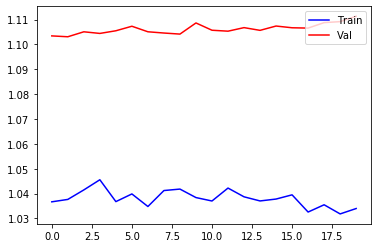

Epoch: 20 | Epoch Time: 0m 20s
	Train Loss: 1.034 | Train Acc: 55.72%
	 Val. Loss: 1.111 |  Val. Acc: 52.64%


In [0]:
N_EPOCHS = 50

best_valid_loss = float('inf')
loss_tracker = LossTracker(plot_freq=1)
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    #if valid_loss < best_valid_loss:
    #    best_valid_loss = valid_loss
    #    torch.save(model.state_dict(), 'tut2-model.pt')

    loss_tracker.log(train_loss, setting='train')
    loss_tracker.log(valid_loss, setting='val')
    loss_tracker.plot()
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')